In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
import h5py
from holotomocupy.proc import remove_outliers




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

npos = 16  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:1]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'1'
path = f'/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01/'

## Read data

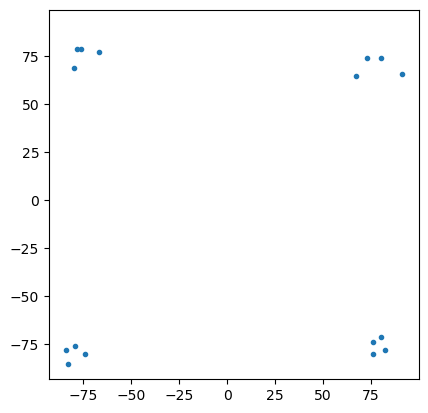

In [3]:
nref = 20
ndark = 20
data00 = np.zeros([1,npos,n,n],dtype='float32')
ref00 = np.zeros([nref,n,n],dtype='float32')
dark00 = np.zeros([ndark,n,n],dtype='float32')
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    data00[:] = fid['/entry_0000/measurement/data'][:npos][np.newaxis]
with h5py.File(f'{path}/ref_0000.h5','r') as fid:
    ref00[:]=fid['/entry_0000/measurement/data'][:nref]
with h5py.File(f'{path}/dark_0000.h5','r') as fid:
    dark00[:]=fid['/entry_0000/measurement/data'][:ndark]
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code = np.zeros([1,npos,2],dtype='float32')
shifts_code[:,:,1] = spy
shifts_code[:,:,0] = -spz


# remove outliers

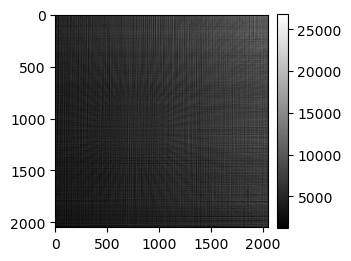

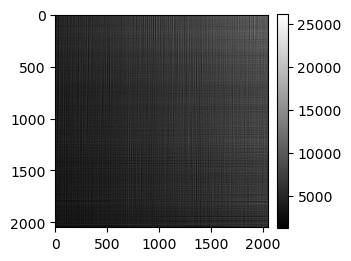

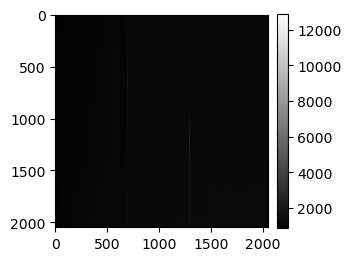

In [4]:
for k in range(npos):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
ref00[:] = remove_outliers(ref00[:], radius, threshold)     
dark00[:] = remove_outliers(dark00[:], radius, threshold)     


mshow(data00[0,0],show)
mshow(ref00[0],show)
mshow(dark00[0],show)

# normalize

In [5]:
data00-=np.mean(dark00)
ref00-=np.mean(dark00)

data00[data00<=0] = 0
ref00[ref00<=0] = 0

data00/=np.mean(ref00)
ref00/=np.mean(ref00)

rdata = (data00-np.mean(dark00,axis=0))/(np.mean(ref00,axis=0)-np.mean(dark00,axis=0))

# check shifts by moving images back to the center

/tmp/ipykernel_1232315/318875278.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])


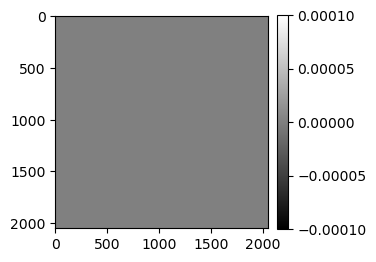

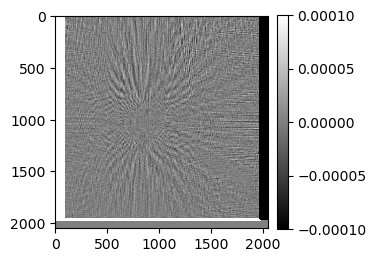

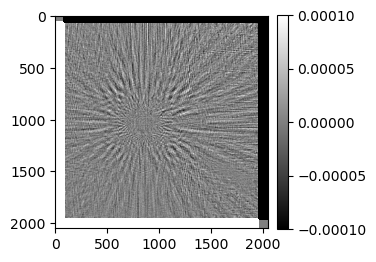

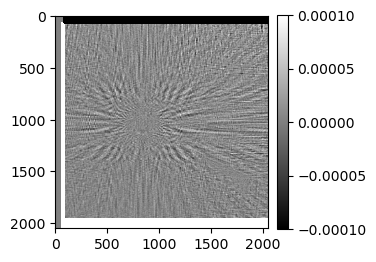

In [6]:
for k in range(npos):
    rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])

for k in range(0,npos,4):
    mshow(rdata[0,k]-rdata[0,0],show,vmin=-1e-4,vmax=1e-4)
    # plt.grid('on')
    # plt.colorbar()
    # plt.show()

# Construct operators


In [7]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(126721688-4.491238594055176j)==
(126721696-1.0132281819119626e-10j)
(83255336-2.90234375j)==
(83255344+2.5532721338095143e-05j)


### Divide by reference image for 1step Paganin reconsturction

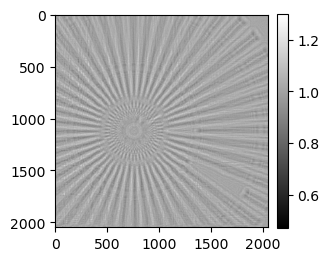

In [8]:
ref0 = cp.array(cp.mean(ref00,axis=0))[np.newaxis,np.newaxis]
data00 = cp.array(data00)
rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=1.3)

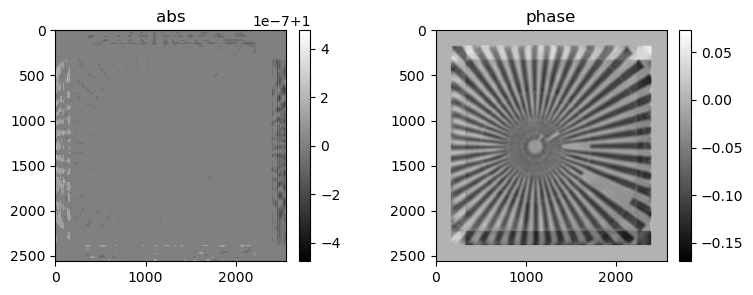

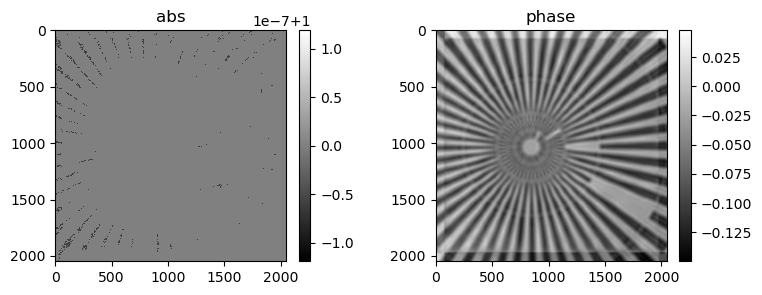

In [9]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='complex64')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='complex64')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 9e-3)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

0) alpha=0.02001, err=4.03002e+05


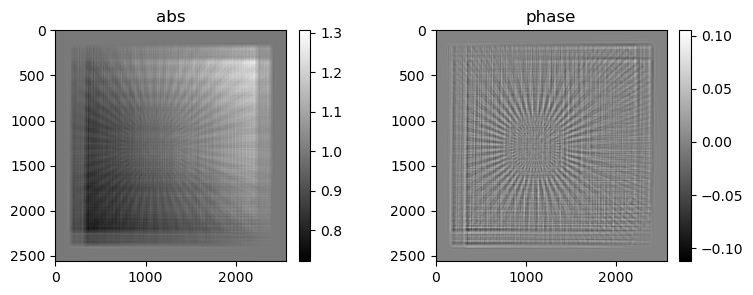

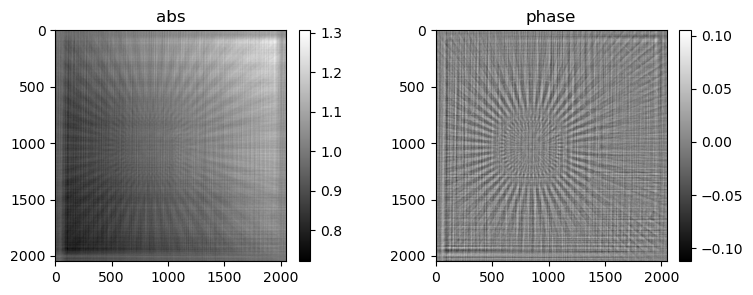

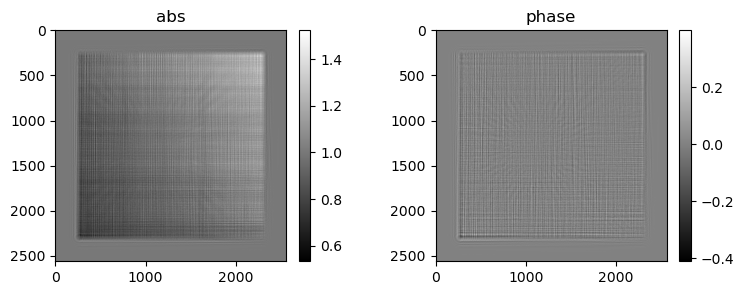

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_000.tiff
1) alpha=0.02425, err=7.58701e+04
2) alpha=0.02453, err=3.28138e+04
3) alpha=0.02693, err=2.19817e+04
4) alpha=0.03634, err=1.87679e+04
5) alpha=0.04127, err=1.72221e+04
6) alpha=0.04106, err=1.61933e+04
7) alpha=0.04804, err=1.52528e+04
8) alpha=0.04872, err=1.44871e+04
9) alpha=0.04630, err=1.38668e+04
10) alpha=0.04658, err=1.33848e+04
11) alpha=0.04954, err=1.29571e+04
12) alpha=0.05151, err=1.25485e+04
13) alpha=0.05679, err=1.21104e+04
14) alpha=0.05476, err=1.16632e+04
15) alpha=0.04900, err=1.12259e+04
16) alpha=0.04744, err=1.08254e+04


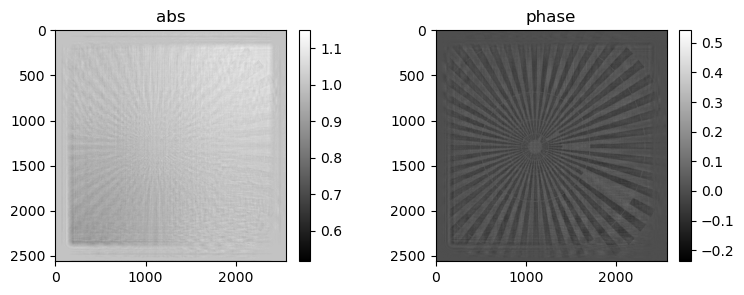

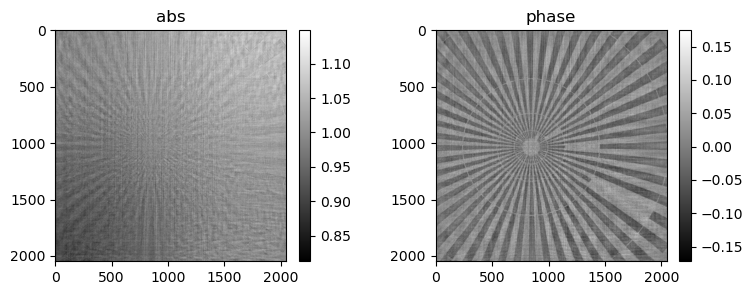

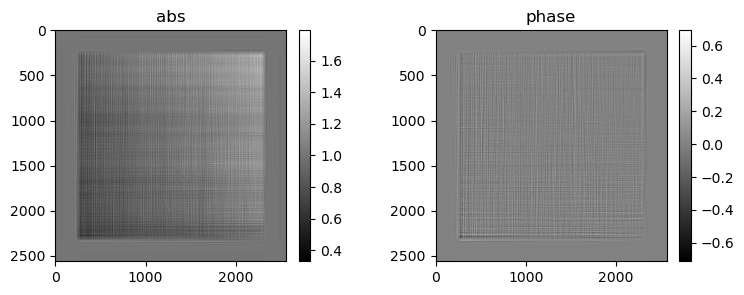

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_016.tiff
17) alpha=0.04733, err=1.04933e+04
18) alpha=0.04552, err=1.02254e+04
19) alpha=0.04881, err=9.98915e+03
20) alpha=0.04905, err=9.77805e+03
21) alpha=0.04945, err=9.57644e+03
22) alpha=0.05199, err=9.37915e+03
23) alpha=0.05037, err=9.19765e+03
24) alpha=0.04724, err=9.02907e+03
25) alpha=0.04777, err=8.87105e+03
26) alpha=0.04805, err=8.72831e+03
27) alpha=0.04758, err=8.59907e+03
28) alpha=0.04860, err=8.47537e+03
29) alpha=0.04861, err=8.35411e+03
30) alpha=0.04852, err=8.23463e+03
31) alpha=0.04782, err=8.12065e+03
32) alpha=0.04690, err=8.01852e+03


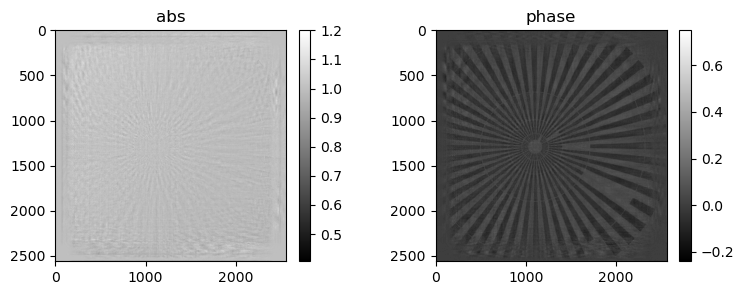

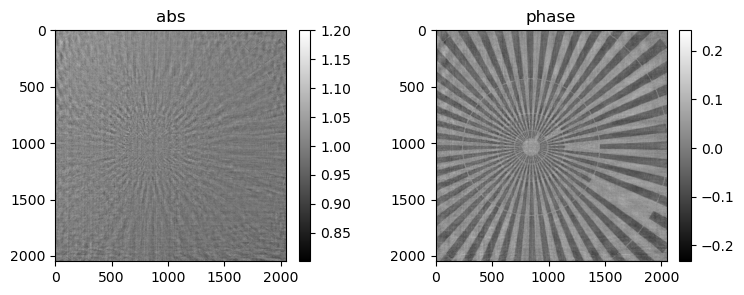

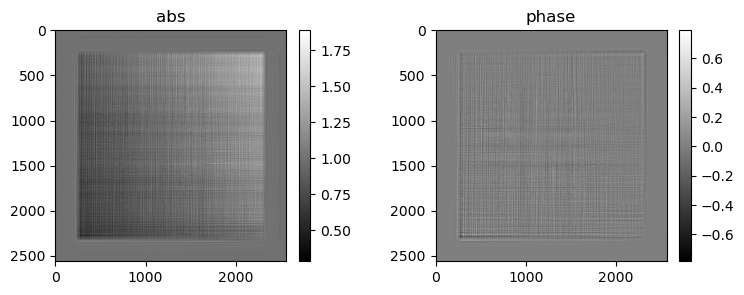

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_032.tiff
33) alpha=0.04691, err=7.92751e+03
34) alpha=0.04794, err=7.84255e+03
35) alpha=0.04737, err=7.75982e+03
36) alpha=0.04854, err=7.67721e+03
37) alpha=0.05012, err=7.59505e+03
38) alpha=0.05106, err=7.51460e+03
39) alpha=0.05109, err=7.43586e+03
40) alpha=0.05001, err=7.36212e+03
41) alpha=0.04628, err=7.29512e+03
42) alpha=0.04772, err=7.22939e+03
43) alpha=0.05072, err=7.16254e+03
44) alpha=0.05066, err=7.09763e+03
45) alpha=0.04790, err=7.03457e+03
46) alpha=0.04752, err=6.97217e+03
47) alpha=0.04807, err=6.90833e+03
48) alpha=0.04921, err=6.84651e+03


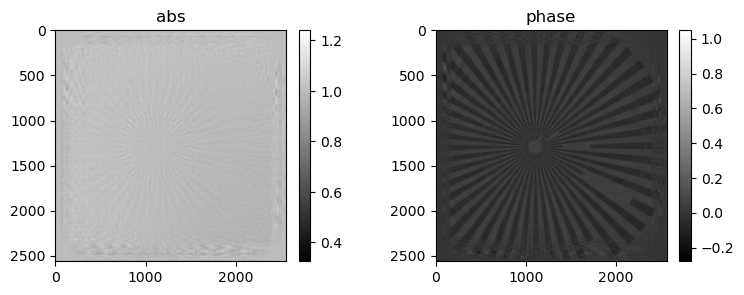

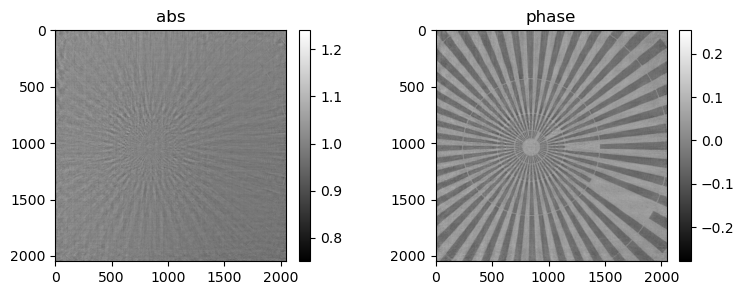

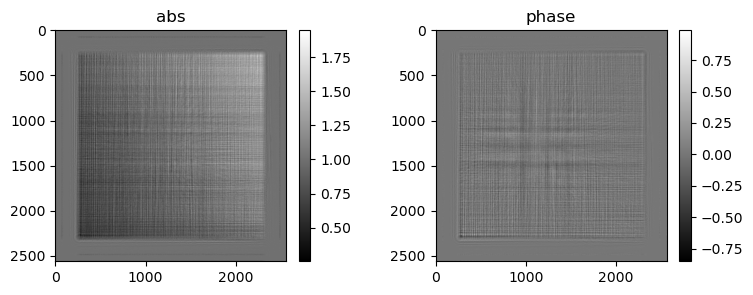

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_048.tiff
49) alpha=0.04948, err=6.78762e+03
50) alpha=0.04885, err=6.73190e+03
51) alpha=0.04953, err=6.67578e+03
52) alpha=0.04983, err=6.61944e+03
53) alpha=0.04922, err=6.56321e+03
54) alpha=0.04924, err=6.50870e+03
55) alpha=0.04774, err=6.45729e+03
56) alpha=0.04846, err=6.40781e+03
57) alpha=0.05023, err=6.35916e+03
58) alpha=0.04863, err=6.31346e+03
59) alpha=0.04758, err=6.26924e+03
60) alpha=0.04913, err=6.22625e+03
61) alpha=0.04937, err=6.18430e+03
62) alpha=0.04786, err=6.14469e+03
63) alpha=0.04762, err=6.10666e+03
64) alpha=0.04895, err=6.07015e+03


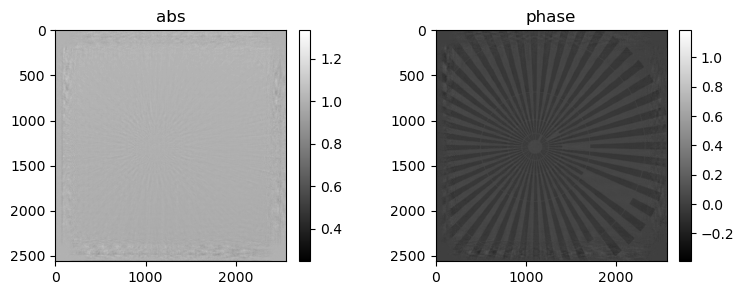

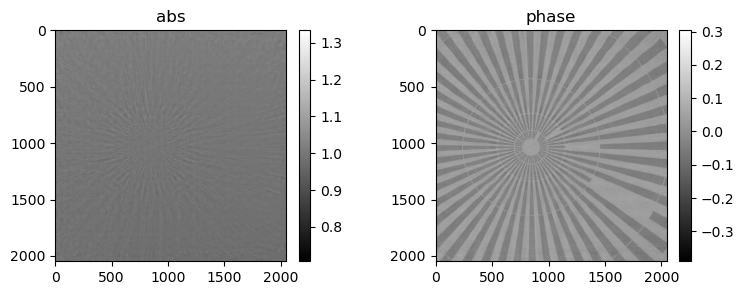

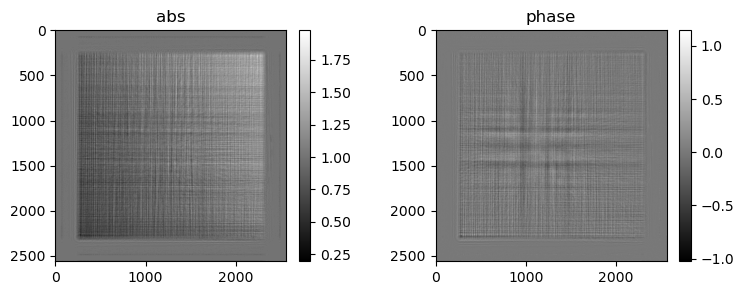

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_064.tiff
65) alpha=0.04952, err=6.03484e+03
66) alpha=0.04880, err=6.00108e+03
67) alpha=0.04966, err=5.96764e+03
68) alpha=0.05076, err=5.93474e+03
69) alpha=0.04919, err=5.90310e+03
70) alpha=0.04847, err=5.87260e+03
71) alpha=0.04933, err=5.84233e+03
72) alpha=0.04981, err=5.81278e+03
73) alpha=0.04847, err=5.78377e+03
74) alpha=0.04919, err=5.75466e+03
75) alpha=0.05072, err=5.72495e+03
76) alpha=0.05059, err=5.69567e+03
77) alpha=0.04872, err=5.66682e+03
78) alpha=0.04920, err=5.63801e+03
79) alpha=0.05057, err=5.60904e+03
80) alpha=0.05079, err=5.58046e+03


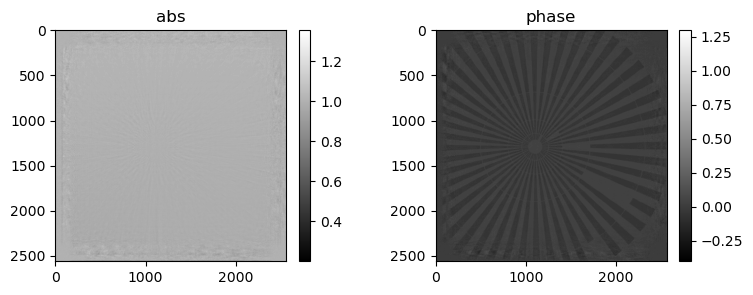

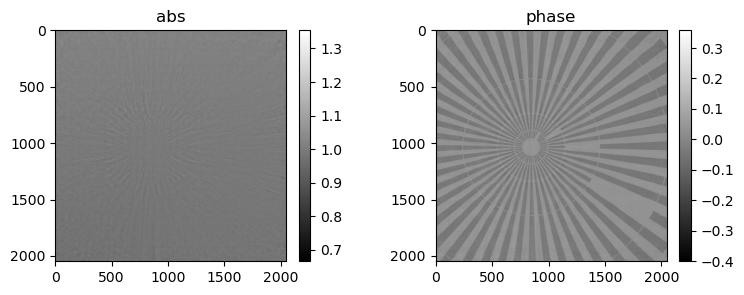

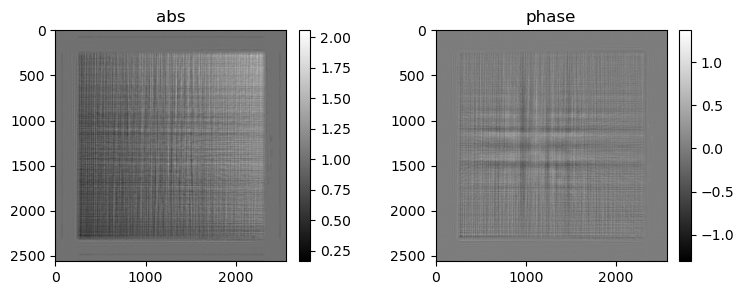

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_080.tiff
81) alpha=0.04920, err=5.55238e+03
82) alpha=0.04892, err=5.52440e+03
83) alpha=0.05009, err=5.49618e+03
84) alpha=0.04946, err=5.46905e+03
85) alpha=0.04813, err=5.44265e+03
86) alpha=0.04940, err=5.41655e+03
87) alpha=0.04914, err=5.39098e+03
88) alpha=0.04851, err=5.36640e+03
89) alpha=0.04912, err=5.34209e+03
90) alpha=0.04984, err=5.31849e+03
91) alpha=0.04905, err=5.29575e+03
92) alpha=0.04910, err=5.27359e+03
93) alpha=0.04952, err=5.25187e+03
94) alpha=0.04869, err=5.23098e+03
95) alpha=0.04868, err=5.21037e+03
96) alpha=0.04994, err=5.19018e+03


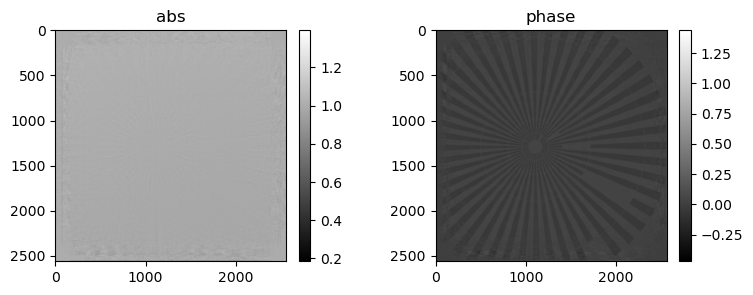

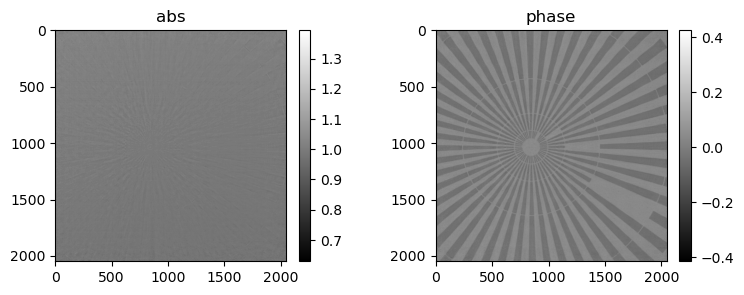

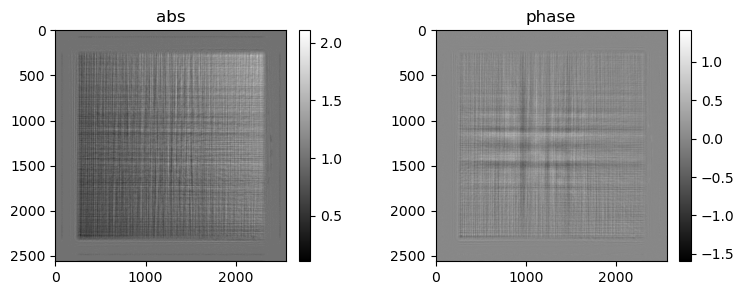

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_096.tiff
97) alpha=0.04860, err=5.17059e+03
98) alpha=0.04845, err=5.15142e+03
99) alpha=0.04969, err=5.13220e+03
100) alpha=0.04997, err=5.11325e+03
101) alpha=0.04950, err=5.09441e+03
102) alpha=0.04922, err=5.07580e+03
103) alpha=0.04969, err=5.05719e+03
104) alpha=0.05004, err=5.03877e+03
105) alpha=0.04902, err=5.02058e+03
106) alpha=0.04919, err=5.00250e+03
107) alpha=0.04935, err=4.98449e+03
108) alpha=0.04956, err=4.96670e+03
109) alpha=0.04938, err=4.94911e+03
110) alpha=0.04909, err=4.93192e+03
111) alpha=0.04864, err=4.91503e+03
112) alpha=0.04908, err=4.89851e+03


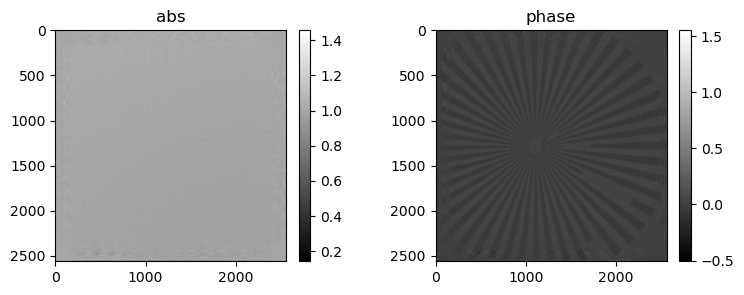

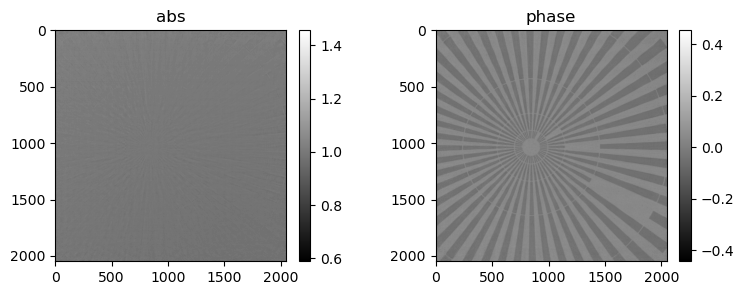

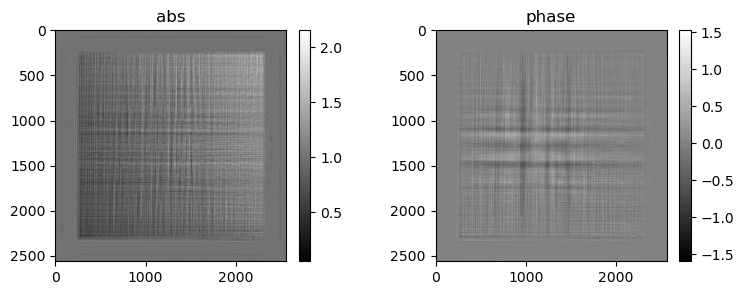

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_112.tiff
113) alpha=0.04881, err=4.88226e+03
114) alpha=0.04947, err=4.86635e+03
115) alpha=0.04913, err=4.85075e+03
116) alpha=0.04939, err=4.83555e+03
117) alpha=0.04941, err=4.82065e+03
118) alpha=0.04908, err=4.80619e+03
119) alpha=0.04894, err=4.79200e+03
120) alpha=0.04869, err=4.77819e+03
121) alpha=0.04844, err=4.76459e+03
122) alpha=0.04955, err=4.75113e+03
123) alpha=0.04936, err=4.73785e+03
124) alpha=0.04954, err=4.72484e+03
125) alpha=0.04926, err=4.71197e+03
126) alpha=0.04958, err=4.69930e+03
127) alpha=0.04938, err=4.68677e+03
128) alpha=0.04925, err=4.67449e+03


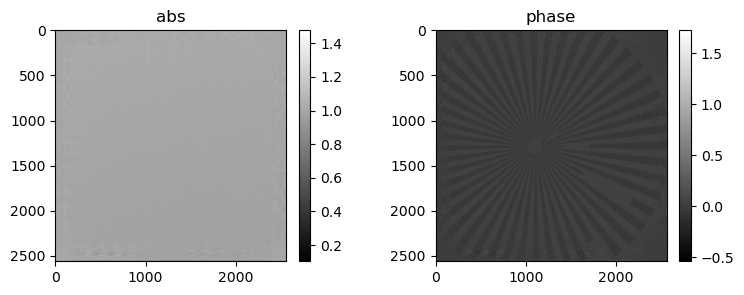

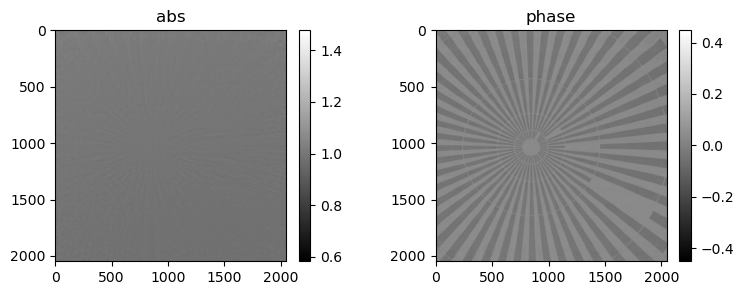

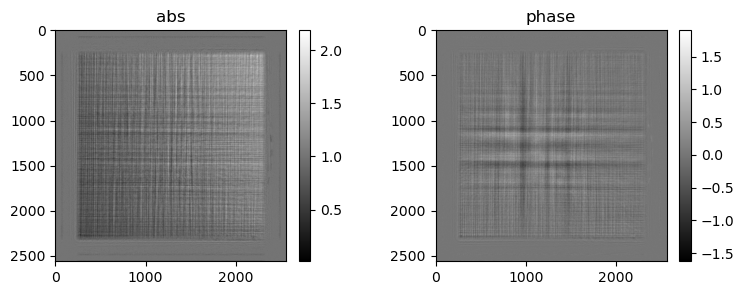

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_128.tiff
129) alpha=0.04900, err=4.66234e+03
130) alpha=0.04936, err=4.65040e+03
131) alpha=0.04940, err=4.63857e+03
132) alpha=0.04906, err=4.62704e+03
133) alpha=0.04850, err=4.61568e+03
134) alpha=0.04958, err=4.60442e+03
135) alpha=0.04960, err=4.59337e+03
136) alpha=0.04945, err=4.58257e+03
137) alpha=0.04872, err=4.57201e+03
138) alpha=0.04885, err=4.56167e+03
139) alpha=0.04914, err=4.55142e+03
140) alpha=0.04992, err=4.54133e+03
141) alpha=0.04959, err=4.53140e+03
142) alpha=0.04922, err=4.52175e+03
143) alpha=0.04854, err=4.51225e+03
144) alpha=0.04942, err=4.50287e+03


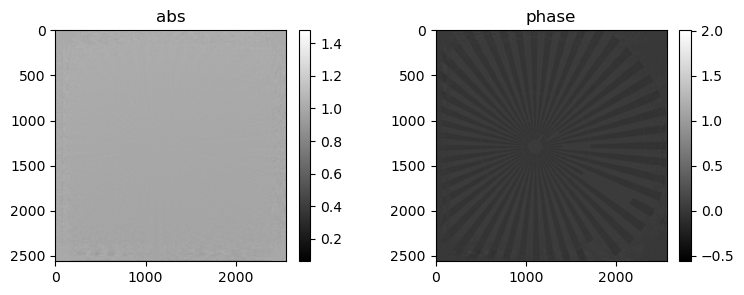

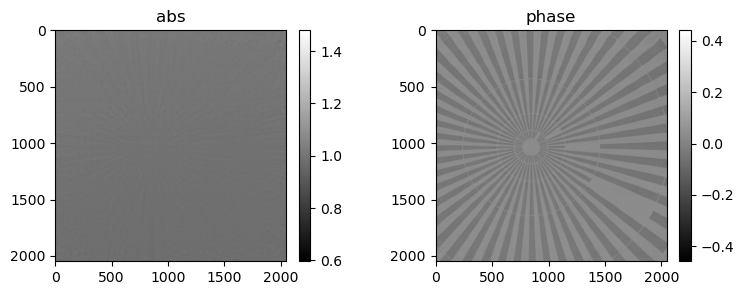

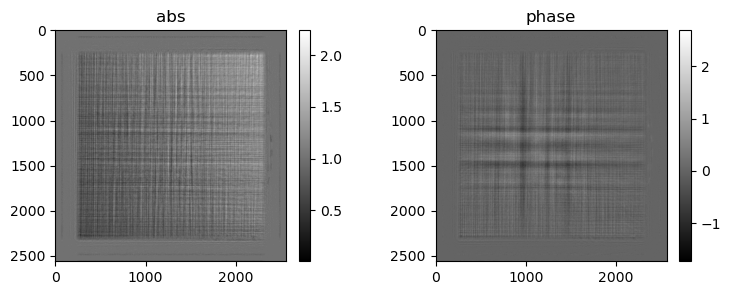

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_144.tiff
145) alpha=0.04924, err=4.49361e+03
146) alpha=0.04915, err=4.48452e+03
147) alpha=0.04895, err=4.47556e+03
148) alpha=0.04944, err=4.46671e+03
149) alpha=0.04945, err=4.45795e+03
150) alpha=0.04980, err=4.44930e+03
151) alpha=0.04940, err=4.44078e+03
152) alpha=0.04939, err=4.43243e+03
153) alpha=0.04871, err=4.42421e+03
154) alpha=0.04934, err=4.41608e+03
155) alpha=0.04940, err=4.40804e+03
156) alpha=0.04912, err=4.40018e+03
157) alpha=0.04878, err=4.39243e+03
158) alpha=0.04942, err=4.38476e+03
159) alpha=0.04929, err=4.37720e+03
160) alpha=0.04944, err=4.36979e+03


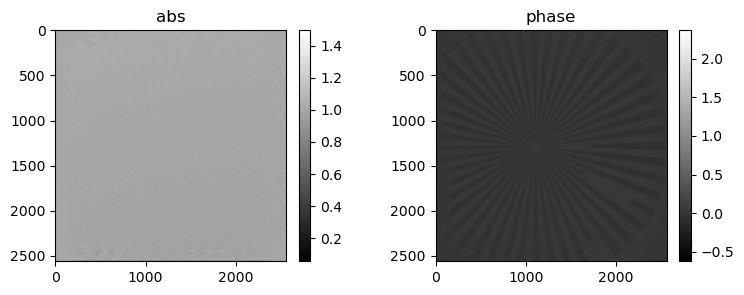

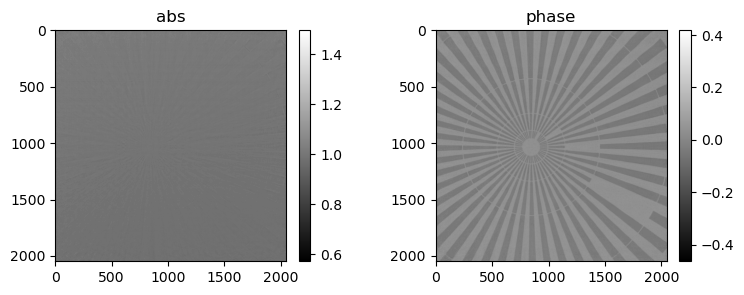

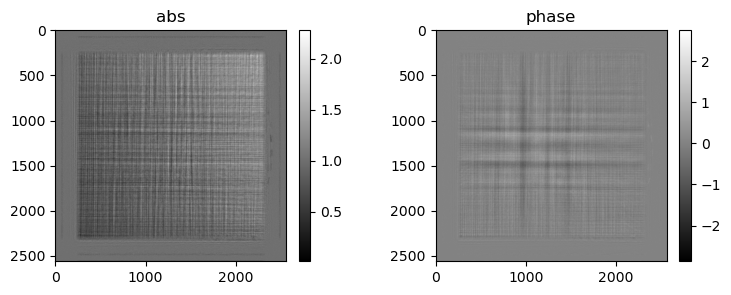

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_160.tiff
161) alpha=0.04903, err=4.36248e+03
162) alpha=0.04948, err=4.35528e+03
163) alpha=0.04922, err=4.34817e+03
164) alpha=0.04944, err=4.34118e+03
165) alpha=0.04910, err=4.33430e+03
166) alpha=0.04906, err=4.32754e+03
167) alpha=0.04880, err=4.32085e+03
168) alpha=0.04968, err=4.31424e+03
169) alpha=0.04925, err=4.30774e+03
170) alpha=0.04910, err=4.30136e+03
171) alpha=0.04889, err=4.29504e+03
172) alpha=0.04930, err=4.28880e+03
173) alpha=0.04926, err=4.28263e+03
174) alpha=0.04973, err=4.27654e+03
175) alpha=0.04928, err=4.27053e+03
176) alpha=0.04930, err=4.26463e+03


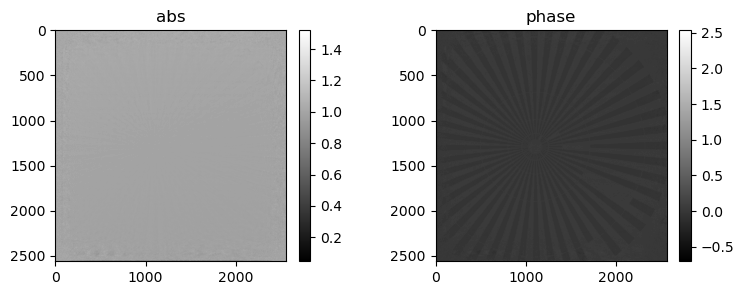

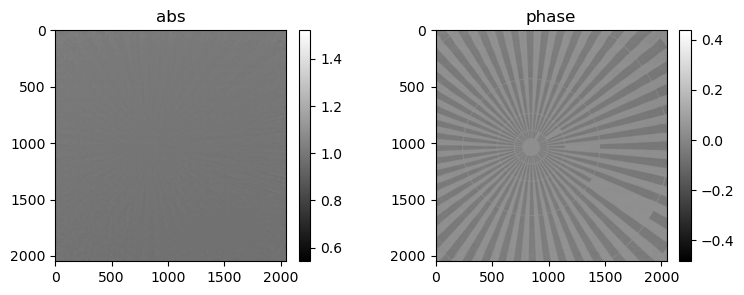

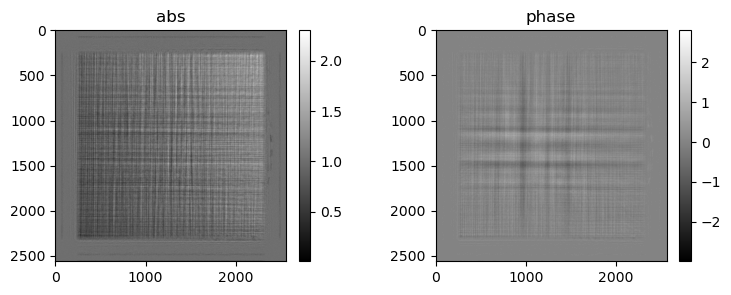

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_176.tiff
177) alpha=0.04881, err=4.25880e+03
178) alpha=0.04938, err=4.25303e+03
179) alpha=0.04902, err=4.24734e+03
180) alpha=0.04925, err=4.24173e+03
181) alpha=0.04910, err=4.23618e+03
182) alpha=0.04916, err=4.23072e+03
183) alpha=0.04898, err=4.22532e+03
184) alpha=0.04962, err=4.21998e+03
185) alpha=0.04926, err=4.21471e+03
186) alpha=0.04940, err=4.20952e+03
187) alpha=0.04877, err=4.20441e+03
188) alpha=0.04936, err=4.19935e+03
189) alpha=0.04940, err=4.19433e+03
190) alpha=0.04938, err=4.18940e+03
191) alpha=0.04881, err=4.18454e+03
192) alpha=0.04917, err=4.17974e+03


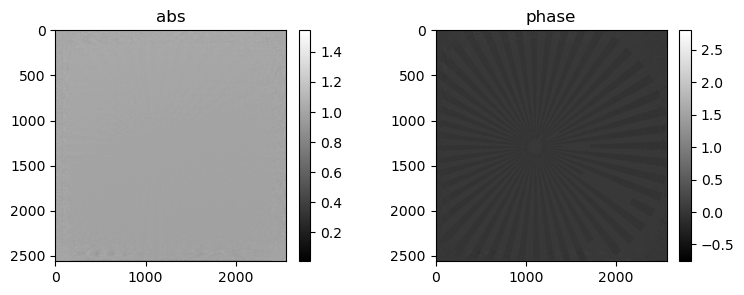

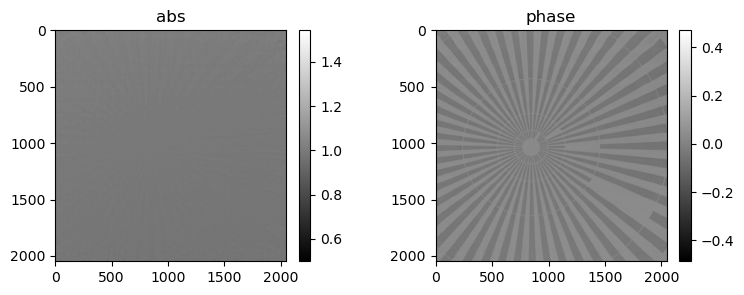

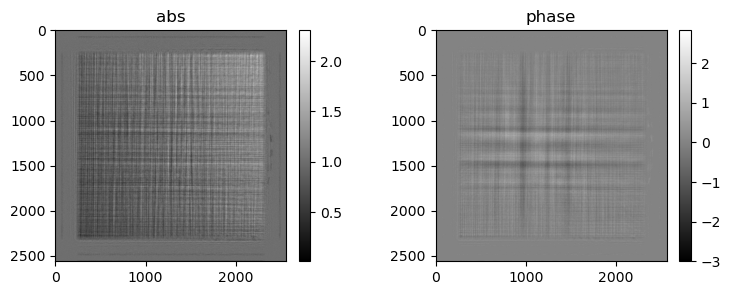

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_192.tiff
193) alpha=0.04885, err=4.17499e+03
194) alpha=0.04937, err=4.17030e+03
195) alpha=0.04930, err=4.16565e+03
196) alpha=0.04958, err=4.16106e+03
197) alpha=0.04888, err=4.15654e+03
198) alpha=0.04945, err=4.15206e+03
199) alpha=0.04925, err=4.14763e+03
200) alpha=0.04936, err=4.14326e+03
201) alpha=0.04907, err=4.13894e+03
202) alpha=0.04913, err=4.13470e+03
203) alpha=0.04873, err=4.13050e+03
204) alpha=0.04942, err=4.12634e+03
205) alpha=0.04923, err=4.12222e+03
206) alpha=0.04934, err=4.11815e+03
207) alpha=0.04905, err=4.11413e+03
208) alpha=0.04944, err=4.11016e+03


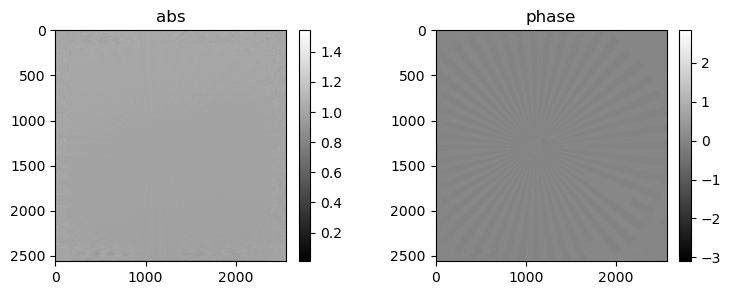

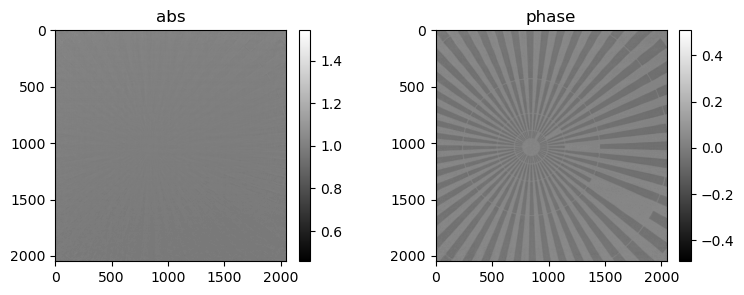

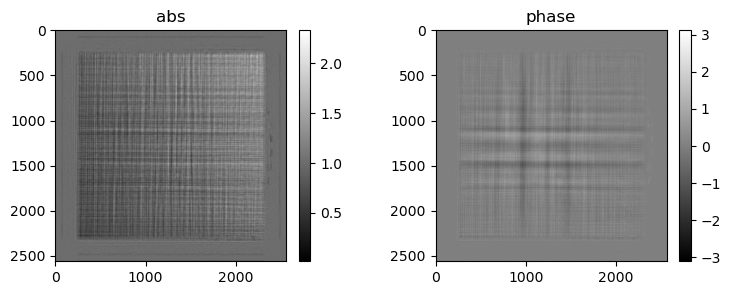

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_208.tiff
209) alpha=0.04923, err=4.10622e+03
210) alpha=0.04962, err=4.10233e+03
211) alpha=0.04869, err=4.09850e+03
212) alpha=0.04898, err=4.09471e+03
213) alpha=0.04944, err=4.09093e+03
214) alpha=0.04977, err=4.08721e+03
215) alpha=0.04899, err=4.08354e+03
216) alpha=0.04895, err=4.07992e+03
217) alpha=0.04885, err=4.07632e+03
218) alpha=0.04935, err=4.07276e+03
219) alpha=0.04931, err=4.06923e+03
220) alpha=0.04945, err=4.06575e+03
221) alpha=0.04891, err=4.06231e+03
222) alpha=0.04945, err=4.05890e+03
223) alpha=0.04929, err=4.05552e+03
224) alpha=0.04947, err=4.05218e+03


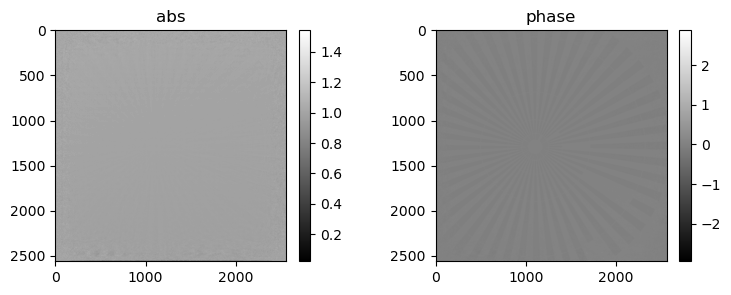

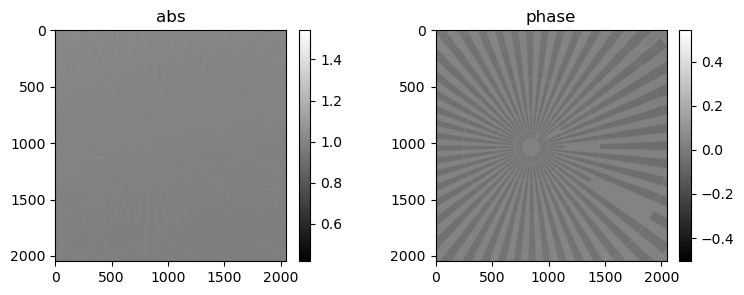

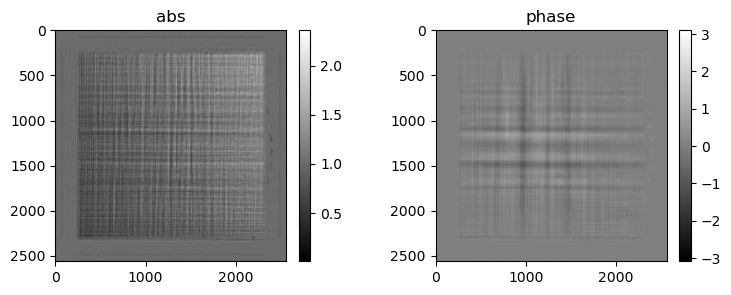

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_224.tiff
225) alpha=0.04896, err=4.04888e+03
226) alpha=0.04913, err=4.04562e+03
227) alpha=0.04871, err=4.04240e+03
228) alpha=0.04938, err=4.03919e+03
229) alpha=0.04920, err=4.03601e+03
230) alpha=0.04924, err=4.03287e+03
231) alpha=0.04910, err=4.02976e+03
232) alpha=0.04963, err=4.02667e+03
233) alpha=0.04920, err=4.02362e+03
234) alpha=0.04927, err=4.02061e+03
235) alpha=0.04867, err=4.01764e+03
236) alpha=0.04926, err=4.01469e+03
237) alpha=0.04917, err=4.01176e+03
238) alpha=0.04931, err=4.00887e+03
239) alpha=0.04902, err=4.00600e+03
240) alpha=0.04928, err=4.00316e+03


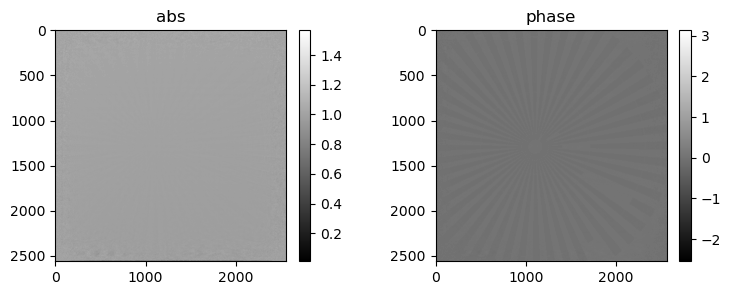

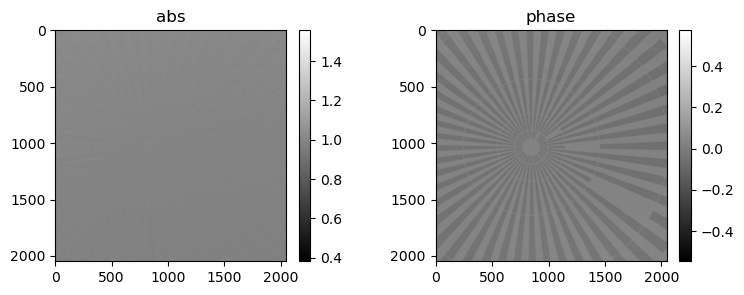

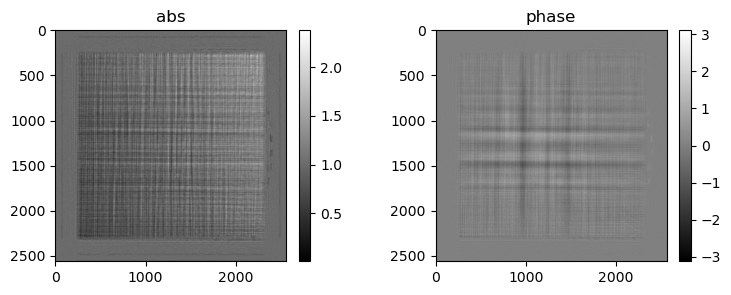

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_240.tiff
241) alpha=0.04893, err=4.00035e+03
242) alpha=0.04932, err=3.99756e+03
243) alpha=0.04913, err=3.99479e+03
244) alpha=0.04933, err=3.99206e+03
245) alpha=0.04884, err=3.98935e+03
246) alpha=0.04945, err=3.98666e+03
247) alpha=0.04930, err=3.98400e+03
248) alpha=0.04928, err=3.98136e+03
249) alpha=0.04894, err=3.97875e+03
250) alpha=0.04925, err=3.97617e+03
251) alpha=0.04865, err=3.97361e+03
252) alpha=0.04921, err=3.97107e+03
253) alpha=0.04907, err=3.96855e+03
254) alpha=0.04939, err=3.96606e+03
255) alpha=0.04912, err=3.96358e+03
256) alpha=0.04935, err=3.96113e+03


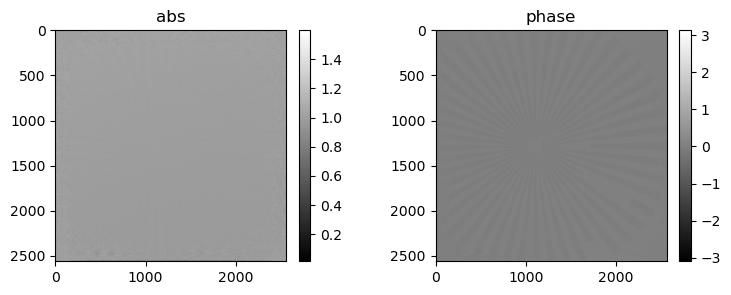

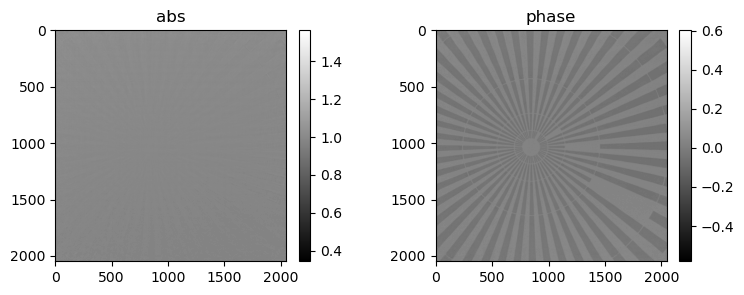

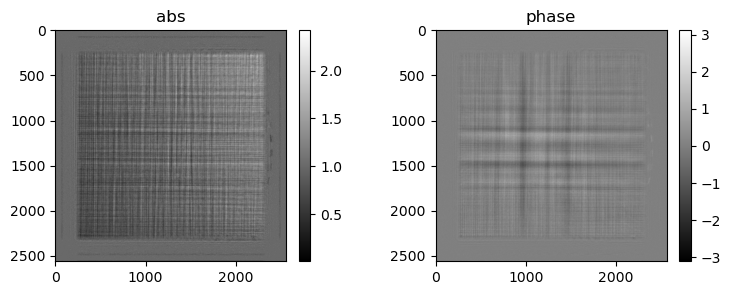

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_256.tiff


In [10]:
def redot(a,b):
    return cp.sum(a.real*b.real+a.imag*b.imag)

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = redot(1-d0,cp.real(Lpsi1*cp.conj(Lpsi2)))
    v2 = redot(d0,cp.real(cp.conj(l0)*Lpsi1)*cp.real(cp.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def cg_holo(data, init_psi,init_prb,  pars):
    
    data = np.sqrt(data)
    
    psi = init_psi.copy()
    prb = init_prb.copy()

    erra = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])
    
    for i in range(pars['niter']):                                        
        
        Lpsi = Lop(Sop(psi)*prb)                
        gradx = 2*LTop(Lpsi-data*(Lpsi/cp.abs(Lpsi)))  
        
        gradpsi = STop(gradx*cp.conj(prb))                     
        gradprb = cp.sum(gradx*cp.conj(Sop(psi)),axis=1)
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            Lpsi = Lop(Sop(psi)*prb)            
            Lksi = Lop(Sop(gradpsi)*prb+Sop(psi)*gradprb)   
            Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)     
            # top
            top = hessian2(Lpsi,Lksi,Leta,data)
            top += redot(gradx,Sop(gradpsi)*etaprb+Sop(etapsi)*gradprb)
            # bottom
            bottom = hessian2(Lpsi,Leta,Leta,data)
            bottom += 2*redot(gradx,Sop(etapsi)*etaprb)

            beta = top/bottom
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -redot(gradpsi,etapsi)-redot(gradprb,etaprb)
        # bottom
        Lpsi = Lop(Sop(psi)*prb)
        Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)
        
        bottom = hessian2(Lpsi,Leta,Leta,data)
        bottom += 2*redot(gradx,Sop(etapsi)*etaprb)
        
        alpha = top/bottom

        psi += alpha*etapsi
        prb += alpha*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi,data)
            erra[i] = err
            alphaa[i] = alpha
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step']>0 :
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)
            dxchange.write_tiff(cp.angle(psi).get(),f'{path}/rec/rec_psi_ang_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.angle(prb).get(),f'{path}/rec/rec_prb_ang_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(psi).get(),f'{path}/rec/rec_psi_abs_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(prb).get(),f'{path}/rec/rec_prb_abs_{flg}_{i:03}',overwrite=True)
            print(f'{path}/rec/rec_psi_{flg}_{i:03}.tiff')

    return psi,prb,erra,alphaa

# fully on gpu
rec_psi = cp.ones([1,ne,ne],dtype='complex64')#recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter':257, 'err_step': 1, 'vis_step': 16}
rec_psi,rec_prb,erra,alphaa = cg_holo(data,rec_psi,rec_prb, pars)